In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import sys
import STAGATE_pyG

dirs='Data/2.6/'
name=[151507,151508,151509,151510,
      151669,151670,151671,151672,
      151673,151674,151675,151676]
result=[]
for i in range(len(name)):
    adata=sc.read_h5ad(dirs+'10X_Visium_maynard2021trans_{}_data.h5ad'.format(name[i]))
    adata=adata[np.logical_not(adata.obs['Region'].isna())]
    #Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    #Constructing the spatial network
    STAGATE_pyG.Cal_Spatial_Net(adata,k_cutoff=6,model='KNN')
    STAGATE_pyG.Stats_Spatial_Net(adata)

    #Running STAGATE
    adata = STAGATE_pyG.train_STAGATE(adata)
    result.append(adata)

In [2]:
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
--- 样本 151507 ---


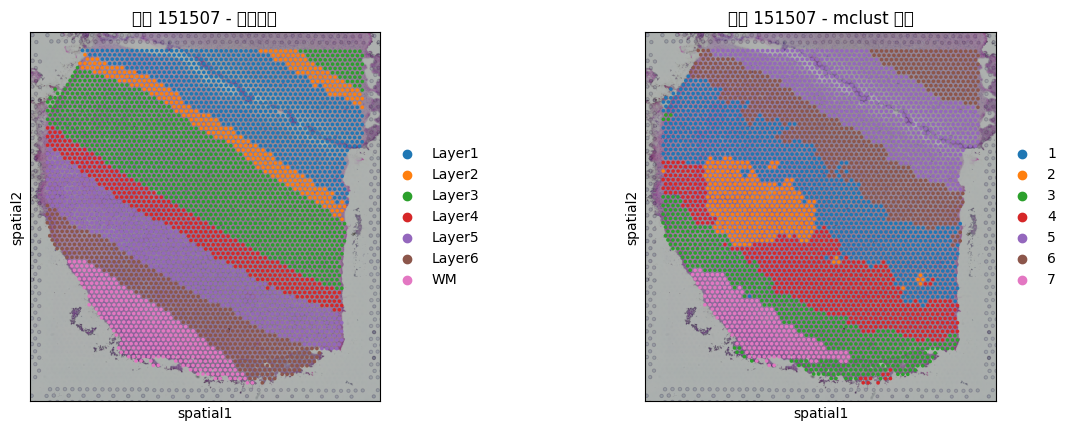

fitting ...
  |======================================================================| 100%
--- 样本 151508 ---


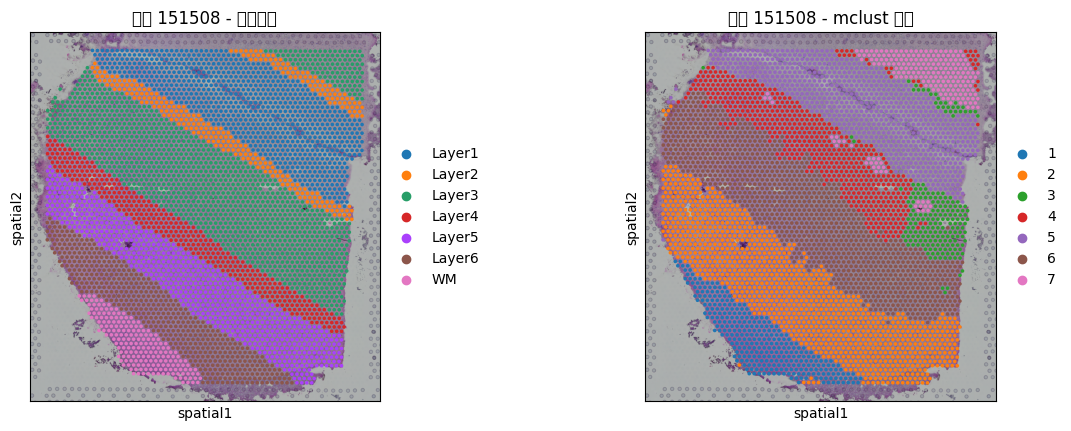

fitting ...
  |======================================================================| 100%
--- 样本 151509 ---


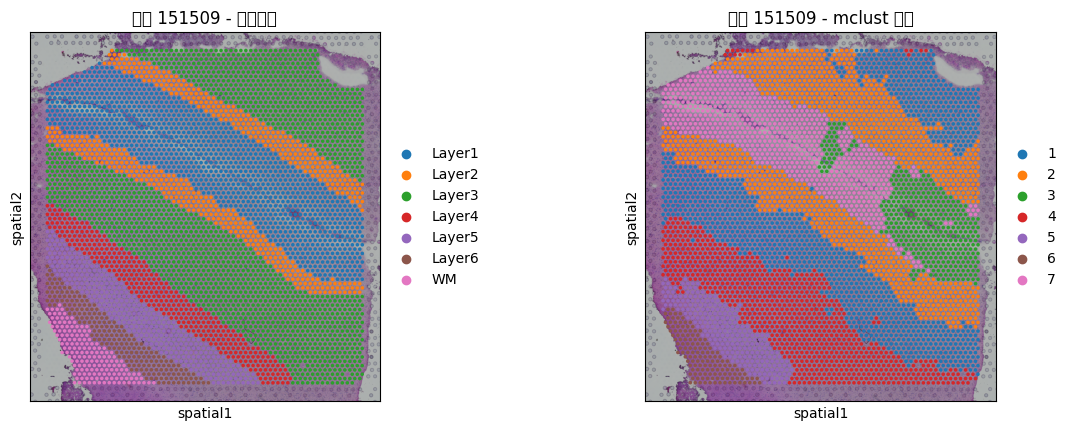

fitting ...
  |======================================================================| 100%
--- 样本 151510 ---


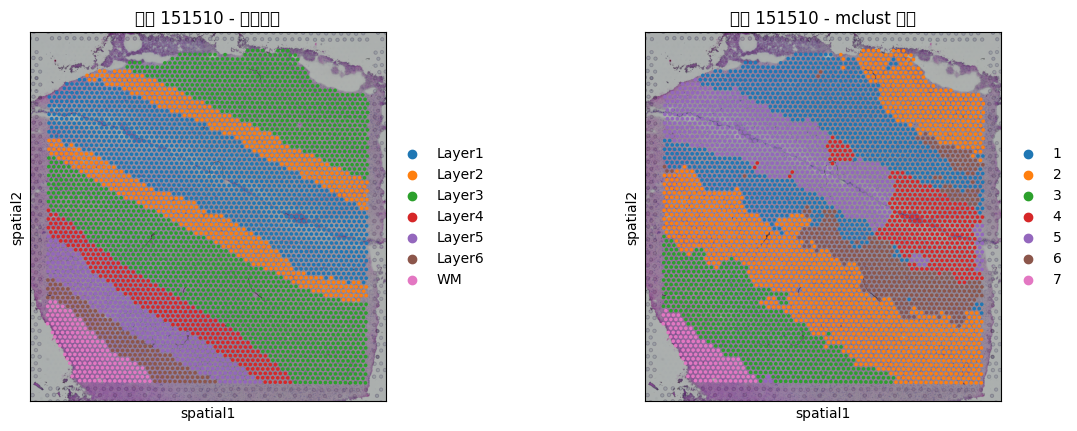

fitting ...
  |======================================================================| 100%
--- 样本 151669 ---


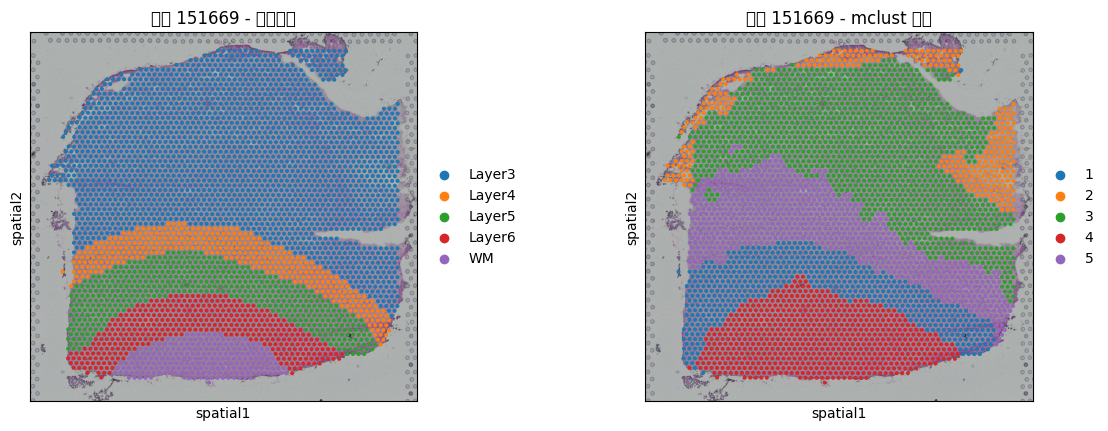

fitting ...
  |======================================================================| 100%
--- 样本 151670 ---


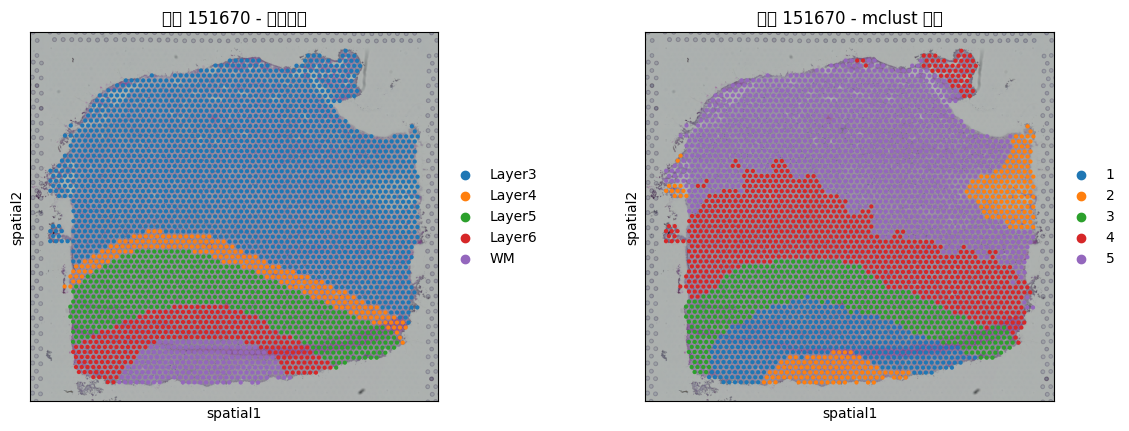

fitting ...
  |======================================================================| 100%
--- 样本 151671 ---


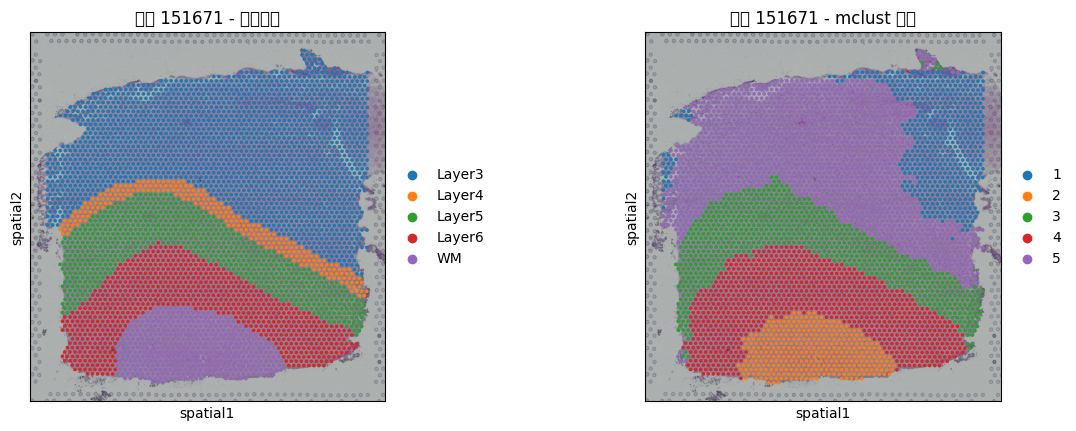

fitting ...
  |======================================================================| 100%
--- 样本 151672 ---


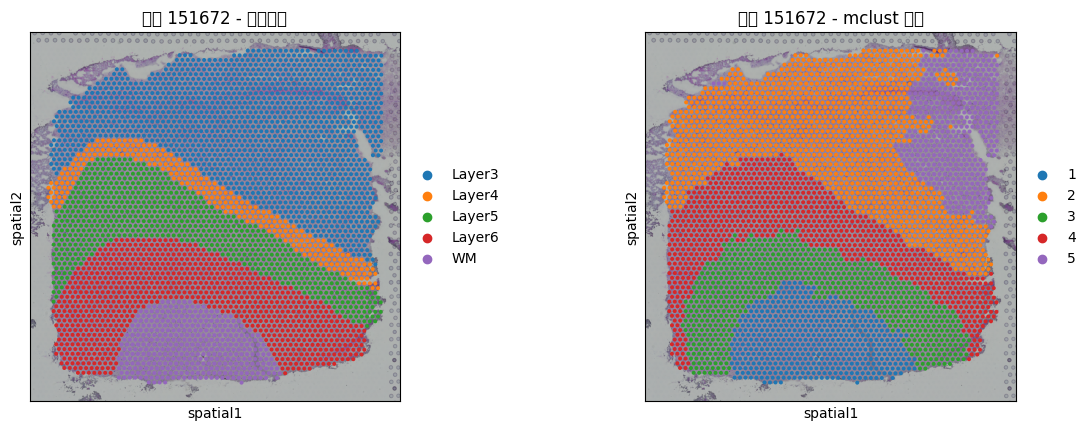

fitting ...
  |======================================================================| 100%
--- 样本 151673 ---


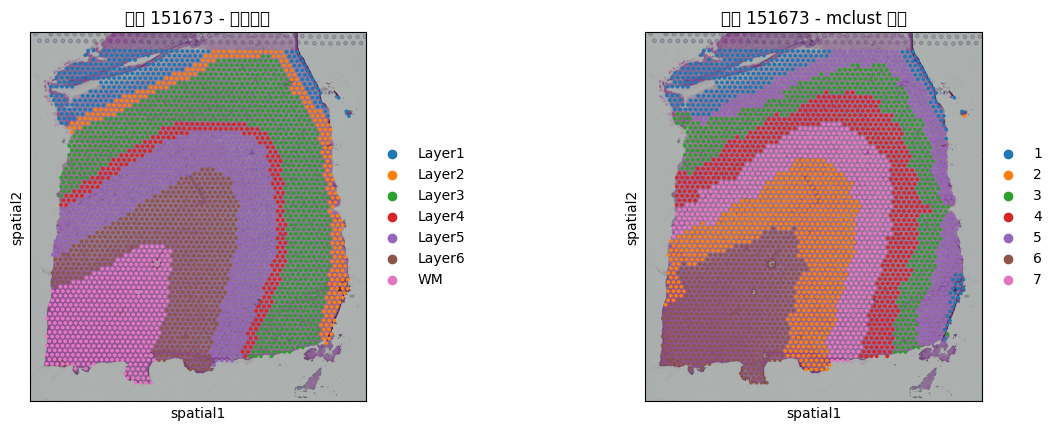

fitting ...
  |======================================================================| 100%
--- 样本 151674 ---


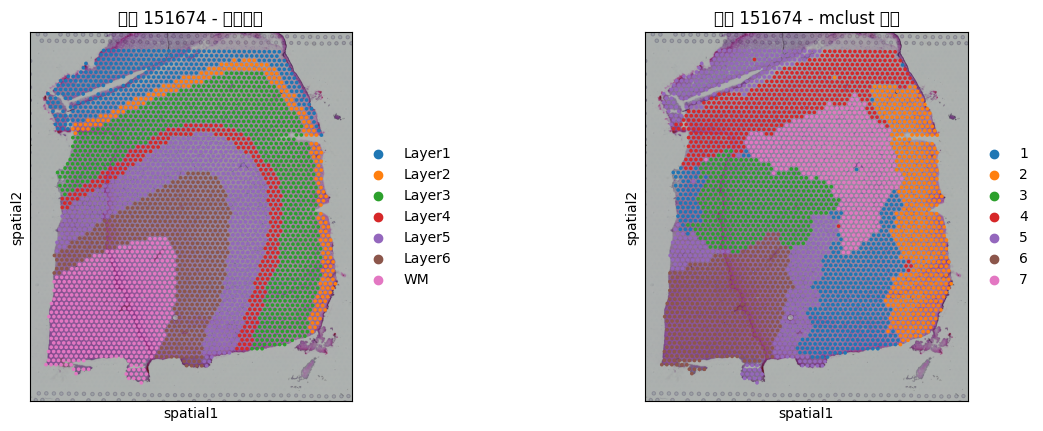

fitting ...
  |======================================================================| 100%
--- 样本 151675 ---


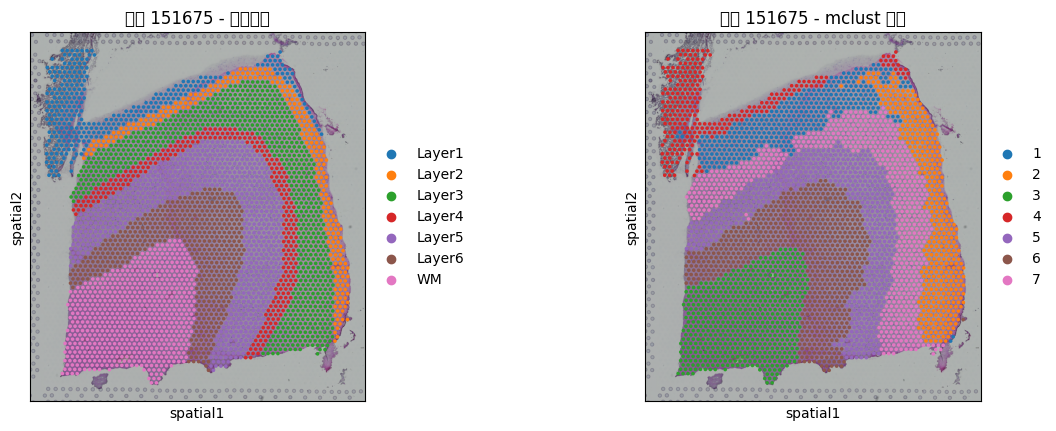

fitting ...
  |======================================================================| 100%
--- 样本 151676 ---


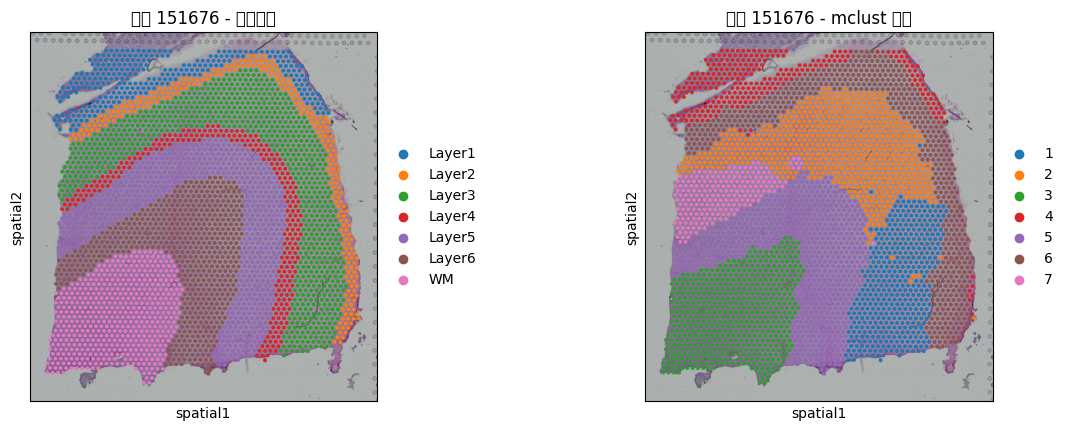

In [ ]:
import matplotlib.pyplot as plt

# 遍历每个样本的处理结果
for i, adata in enumerate(result):
    # 确定聚类数量，使用真实标签的类别数
    n_clusters = len(adata.obs['Region'].unique())
    
    # 使用您自己编写的 mclust_R 函数进行聚类
    # 函数会将结果保存在 adata.obs['mclust']
    mclust_R(adata, num_cluster=n_clusters)
    adata.write(dirs+f'STAGATE_Result_{name[i]}.h5ad')
    # 使用scanpy进行空间可视化
    # 一张图显示真实标签（Region），另一张显示 mclust 聚类标签
    print(f"--- 样本 {name[i]} ---")
    sc.pl.spatial(
        adata,
        color=["Region", "mclust"],
        title=[f"Slice {name[i]} - Ground Truth", f"Slice {name[i]} - mclust result"],
        spot_size=100  # 您可以根据需要调整此值
    )
    plt.show()